In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import itertools

Read the data

In [79]:
df = pd.read_csv('bot_iot.csv')
df.shape

C:\Users\009kr\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(668522, 46)

In [80]:
df.head()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,3000001,1.528099e+09,e,1,udp,3,192.168.100.147,6226,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
1,3000002,1.528099e+09,e,1,udp,3,192.168.100.147,6227,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
2,3000003,1.528099e+09,e,1,udp,3,192.168.100.147,6228,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
3,3000004,1.528099e+09,e,1,udp,3,192.168.100.147,6229,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
4,3000005,1.528099e+09,e,1,udp,3,192.168.100.147,6230,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP


In [81]:
df.category.unique()

array(['DDoS', 'Normal', 'Reconnaissance', 'Theft'], dtype=object)

In [82]:
df['category'] = df['category'].apply(lambda x: x if x in ['DDoS'] else 'Other')

In [83]:
#label encode the output column
category_map = {'DDoS':0, 'Other':1}
df['category'] = df['category'].replace(category_map)

In [84]:
df.category.value_counts()

0    576884
1     91638
Name: category, dtype: int64

In [85]:
df.pkSeqID.unique().size

668522

Check information regarding the features

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   pkSeqID                           668522 non-null  int64  
 1   stime                             668522 non-null  float64
 2   flgs                              668522 non-null  object 
 3   flgs_number                       668522 non-null  int64  
 4   proto                             668522 non-null  object 
 5   proto_number                      668522 non-null  int64  
 6   saddr                             668522 non-null  object 
 7   sport                             668522 non-null  object 
 8   daddr                             668522 non-null  object 
 9   dport                             668522 non-null  object 
 10  pkts                              668522 non-null  int64  
 11  bytes                             668522 non-null  i

Data Preprocessing

In [87]:
df.flgs.unique()

array(['e', 'eU', 'e &', 'e d', 'e   t', 'e s', 'e  D', 'e *', 'e g'],
      dtype=object)

In [88]:
#Features not useful
df = df.drop(['flgs','flgs_number'], axis = 1)

In [89]:
df.proto.unique()

array(['udp', 'arp', 'icmp', 'tcp', 'ipv6-icmp'], dtype=object)

In [90]:
#Similar feature exists in numeric format
df = df.drop(['proto'],axis=1)

In [91]:
df.proto_number.unique()

array([3, 2, 4, 1, 5], dtype=int64)

In [92]:
df.saddr.unique()

array(['192.168.100.147', '192.168.100.148', '192.168.100.149',
       '192.168.100.150', '192.168.100.3', '192.168.100.1',
       '192.168.100.7', '192.168.100.4', '192.168.100.27',
       'fe80::250:56ff:febe:254', '192.168.100.46', '192.168.100.6',
       '192.168.100.5', 'fe80::250:56ff:febe:26db',
       'fe80::250:56ff:febe:e9d9', 'fe80::c0c0:aa20:45b9:bdd9',
       'fe80::250:56ff:febe:89ee', 'fe80::2c6a:ff9b:7e14:166a',
       'fe80::250:56ff:febe:bf1a', 'fe80::250:56ff:febe:c038',
       '192.168.100.55'], dtype=object)

In [93]:
#Convert ip/mac addresses to a more useable format
def conv_ip_addr(ip_addr):
    ip_addr = ip_addr.replace(':','.')
    temp = ip_addr.split('.')
    op = ''.join(temp)
    if op.isnumeric():
        op = int(op)
    else:
        op =int(op, 16)
    return op

In [94]:
df.saddr.dtype

dtype('O')

In [95]:
df['saddr'] = df['saddr'].apply(conv_ip_addr)

In [96]:
df['saddr'] = pd.to_numeric(df['saddr'], errors = 'coerce')

In [97]:
df['daddr'] = df['daddr'].apply(conv_ip_addr)

In [98]:
#Unable to find a better way to handle port addresses might change this
df = df.drop(['dport','sport'],axis=1)

In [99]:
df.state.unique()

array(['INT', 'CON', 'URP', 'FIN', 'NRS', 'RST', 'ECO', 'TST', 'MAS',
       'REQ'], dtype=object)

In [100]:
#One hot encode state feature, might be important
df = pd.get_dummies(df, columns=['state'], prefix=['state'])

In [101]:
df = df.drop(['state_number'],axis=1)

In [102]:
df.attack.unique()

array([1, 0], dtype=int64)

In [103]:
df = df.drop(['pkSeqID','attack','subcategory'], axis=1)

CNN without Feature selection

In [104]:
col_to_scale = ['stime','saddr','daddr', 'pkts', 'bytes', 'ltime', 'dur', 
                'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
                'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
                'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
                'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP']

In [105]:
for col in col_to_scale:
    mu = df[col].mean()
    stdd = df[col].std()

    df[col] = (df[col]-mu)/stdd

In [106]:
X = df.drop(['category'],axis=1)
y = df['category']

In [107]:
xtrain, xtest, ytrain, ytest = tts(X,y,test_size=0.2,random_state=42)

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [109]:
xtrain = torch.FloatTensor(xtrain.values).unsqueeze(1)
ytrain = torch.LongTensor(ytrain.values)
xtest = torch.FloatTensor(xtest.values).unsqueeze(1)
ytest = torch.LongTensor(ytest.values)

In [110]:
xtrain, xtest, ytrain, ytest = xtrain.to(device), xtest.to(device),ytrain.to(device), ytest.to(device)

In [111]:
#xtrain, xtest = xtrain.reshape(-1,1,45), xtest.reshape(-1,1,45)

In [112]:
xtrain.shape

torch.Size([534817, 1, 45])

In [113]:
train_dataset = TensorDataset(xtrain, ytrain)

In [114]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [125]:
num_epochs = 7
learning_rate = 0.001

In [126]:
class PrintShape(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

In [127]:
class Multiclass(nn.Module):
    def __init__(self):
        super(Multiclass, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        #PrintShape(),
        nn.BatchNorm1d(16),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(32),
       # pool2 = nn.MaxPool1d(kernel_size=2),
        nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
        nn.Linear(32*22, 64),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(64,3)
        )
        
    
    def forward(self, x):
        #print("Initial input shape:", x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        #print("Before reshaping:", x.shape)
        x = x.view(x.size(0),-1)
        #print("After reshaping:", x.shape)
        x = self.layer3(x)
        return x

In [128]:
model = Multiclass().to(device)

In [129]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [130]:
for e in range(num_epochs):
    loss = 0.0
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {e}"):
        #print("Input data shape:", batch_X.shape)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        #print(f"Epoch {e}, loss = {loss.item():.4f}")
    avg_loss = loss/len(train_loader)
    print(f"Epoch {e} --- Avg loss = {avg_loss:.4f}")

Epoch 0: 100%|██████████| 16714/16714 [02:09<00:00, 129.45it/s]


Epoch 0 --- Avg loss = 0.0000


Epoch 1: 100%|██████████| 16714/16714 [02:00<00:00, 138.26it/s]


Epoch 1 --- Avg loss = 0.0000


Epoch 2: 100%|██████████| 16714/16714 [01:59<00:00, 140.42it/s]


Epoch 2 --- Avg loss = 0.0000


Epoch 3: 100%|██████████| 16714/16714 [02:00<00:00, 138.65it/s]


Epoch 3 --- Avg loss = 0.0000


Epoch 4: 100%|██████████| 16714/16714 [02:01<00:00, 138.09it/s]


Epoch 4 --- Avg loss = 0.0000


Epoch 5: 100%|██████████| 16714/16714 [02:01<00:00, 137.85it/s]


Epoch 5 --- Avg loss = 0.0000


Epoch 6: 100%|██████████| 16714/16714 [02:00<00:00, 138.40it/s]

Epoch 6 --- Avg loss = 0.0000


In [131]:
test_dataset = TensorDataset(xtest, ytest)
test_loader = DataLoader(test_dataset, batch_size=32)

In [134]:
model.eval() 
true = [] 
pred = []
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device) 
        outputs = model(data)
        _, predicted = torch.max(outputs, 1) 

        pred.extend(predicted.cpu().tolist())
        true.extend(labels.tolist())

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = (correct_predictions / total_predictions) * 100
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

Accuracy of the model on the test data: 99.74%


In [133]:
from collections import Counter
counter = Counter(pred)
counter

Counter({0: 115539, 1: 18166})

In [136]:
cm = confusion_matrix(true, pred)

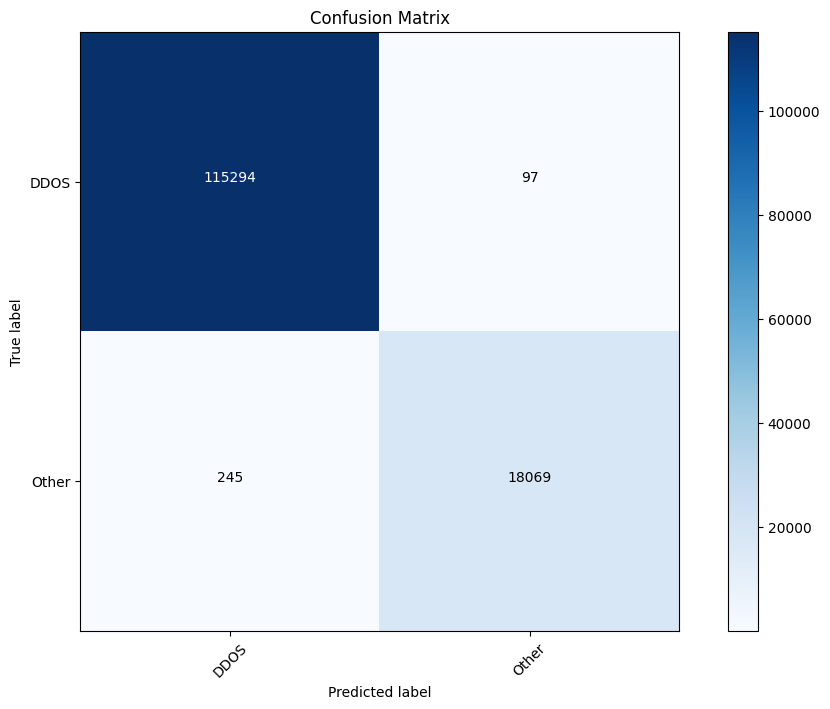

In [138]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Assuming your classes are named 'DDOS', 'Normal', and 'Other'
plot_confusion_matrix(cm, classes=['DDOS', 'Other'])

In [140]:
from sklearn.metrics import f1_score

f1 = f1_score(true, pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9906


Feature Selection

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   stime                             668522 non-null  float64
 1   proto_number                      668522 non-null  int64  
 2   saddr                             668522 non-null  float64
 3   daddr                             668522 non-null  int64  
 4   pkts                              668522 non-null  int64  
 5   bytes                             668522 non-null  int64  
 6   ltime                             668522 non-null  float64
 7   seq                               668522 non-null  int64  
 8   dur                               668522 non-null  float64
 9   mean                              668522 non-null  float64
 10  stddev                            668522 non-null  float64
 11  sum                               668522 non-null  f

In [33]:
#Find correlation matrix of the features
corr_matrix = df.corr()

In [34]:
#correlation of all features with the output feature
corr_with_output = corr_matrix['category'].sort_values(ascending=False)

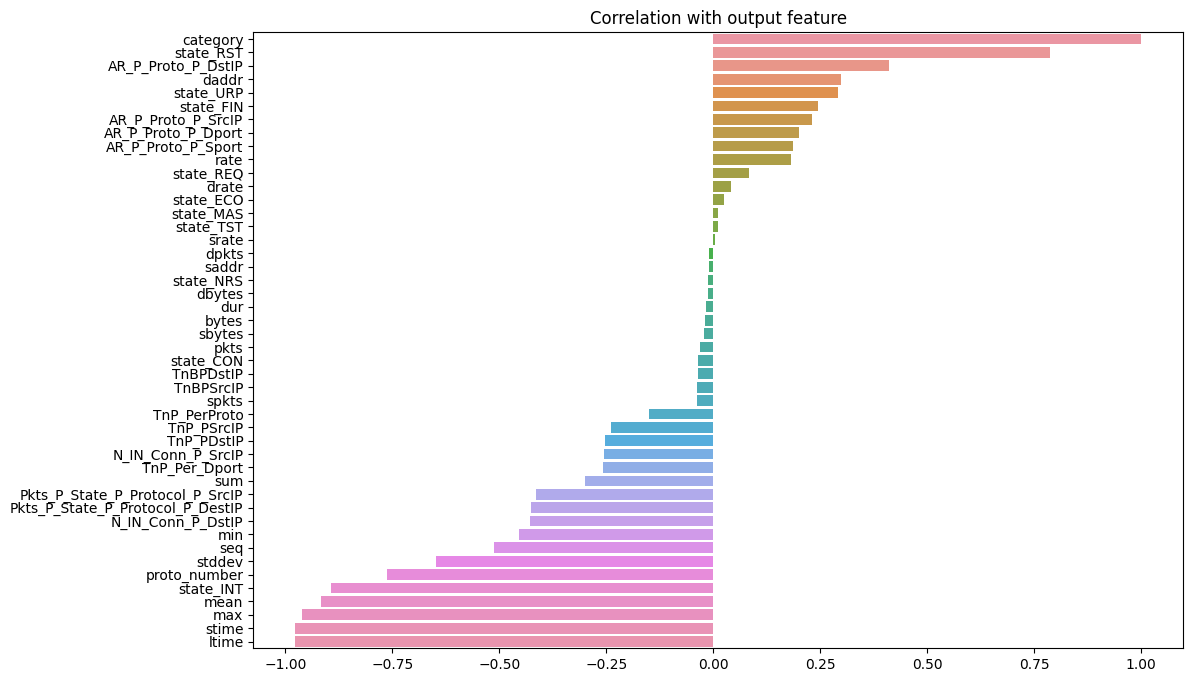

In [35]:
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_with_output.values, y=corr_with_output.index)
plt.title('Correlation with output feature')
plt.show()

In [36]:
useful_features = []
for i in range(len(corr_with_output)):
    if corr_with_output[i] > 0.2 or corr_with_output[i] < -0.2:
        useful_features.append(corr_with_output.index[i])

In [37]:
#We can use these features for our model
useful_features

['category',
 'state_RST',
 'AR_P_Proto_P_DstIP',
 'daddr',
 'state_URP',
 'state_FIN',
 'AR_P_Proto_P_SrcIP',
 'AR_P_Proto_P_Dport',
 'TnP_PSrcIP',
 'TnP_PDstIP',
 'N_IN_Conn_P_SrcIP',
 'TnP_Per_Dport',
 'sum',
 'Pkts_P_State_P_Protocol_P_SrcIP',
 'Pkts_P_State_P_Protocol_P_DestIP',
 'N_IN_Conn_P_DstIP',
 'min',
 'seq',
 'stddev',
 'proto_number',
 'state_INT',
 'mean',
 'max',
 'stime',
 'ltime']

In [30]:
df1 = df[useful_features]

In [31]:
df1.head()

,category,state_RST,AR_P_Proto_P_DstIP,daddr,state_URP,state_FIN,AR_P_Proto_P_SrcIP,AR_P_Proto_P_Dport,TnP_PSrcIP,TnP_PDstIP,...,N_IN_Conn_P_DstIP,min,seq,stddev,proto_number,state_INT,mean,max,stime,ltime
0,1,0,1.09825,1921681003,0,0,1.09825,1.09825,1500,1500,...,100,1.976111,109223,1.367803,3,1,3.91046,4.884452,1.528099e+09,1.528099e+09
1,1,0,1.09825,1921681003,0,0,1.09825,1.09825,1500,1500,...,100,1.976111,109224,1.367802,3,1,3.91046,4.884452,1.528099e+09,1.528099e+09
2,1,0,1.09825,1921681003,0,0,1.09825,1.09825,1500,1500,...,100,1.976111,109225,1.367802,3,1,3.91046,4.884452,1.528099e+09,1.528099e+09
3,1,0,1.09825,1921681003,0,0,1.09825,1.09825,1500,1500,...,100,1.976111,109226,1.367802,3,1,3.91046,4.884452,1.528099e+09,1.528099e+09
4,1,0,1.09825,1921681003,0,0,1.09825,1.09825,1500,1500,...,100,1.976111,109227,1.367803,3,1,3.91046,4.884453,1.528099e+09,1.528099e+09


Export Dataset as CSV for repeated use

In [17]:
df1.to_csv('bot_iot_cleaned.csv', index = False)

NameError: name 'df1' is not defined

Imbalanced Data

In [38]:
df = pd.read_csv('bot_iot_cleaned.csv')
df.shape

(668522, 25)

In [39]:
df.category.value_counts()

1    576884
2     91161
0       477
Name: category, dtype: int64

Data is severely unbalanced

In [136]:
X = df.drop(['category'],axis=1)
y = df.category

In [137]:
xtrain, xtest, ytrain, ytest = tts(X, y, test_size=0.2, random_state=42)

In [138]:
train_df = pd.concat([xtrain, ytrain], axis=1)

In [139]:
train_df.shape

(534817, 25)

In [140]:
train_df.category.value_counts()

1    461493
2     72947
0       377
Name: category, dtype: int64

In [141]:
ddos_df = train_df[train_df.category == 1]
normal_df = train_df[train_df.category == 0]
other_df = train_df[train_df.category == 2]

In [142]:
ddos_df = resample(ddos_df, replace=True, n_samples = 20000, random_state=56)
normal_df = resample(normal_df, replace=True, n_samples = 10000, random_state=42)
other_df = resample(other_df, replace=True, n_samples = 1500, random_state=12)

In [143]:
train_df = pd.concat([ddos_df,normal_df,other_df], axis=0)
train_df.shape

(31500, 25)

In [144]:
xtrain = train_df.drop(['category'], axis=1)
ytrain = train_df['category']

Model Building

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [146]:
xtrain = torch.FloatTensor(xtrain.values)
ytrain = torch.LongTensor(ytrain.values)
xtest = torch.FloatTensor(xtest.values)
ytest = torch.LongTensor(ytest.values)

In [147]:
xtrain, xtest, ytrain, ytest = xtrain.to(device).unsqueeze(2), xtest.to(device).unsqueeze(2),ytrain.to(device), ytest.to(device)

In [148]:
num_epopchs = 1000
batch_size = 32
learning_rate = 0.001

In [149]:
class Multiclass(nn.Module):
    def __init__(self):
        super(Multiclass, self).__init__()
        self.conv1 = nn.Conv1d(24, 16, kernel_size=3, stride=1, padding=1)
        #self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        #self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 3)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [150]:
model = Multiclass().to(device)

In [151]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [152]:
for e in range(num_epopchs):
    outputs = model(xtrain)
    loss = criterion(outputs, ytrain)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (e + 1) % 10 == 0:
        print(f"Epoch [{e+1}/{e}], loss = {loss.item():.4f}")

Epoch [10/9], loss = 1913564.1250
Epoch [20/19], loss = 531034.0625
Epoch [30/29], loss = 926859.6250
Epoch [40/39], loss = 260350.7656
Epoch [50/49], loss = 410858.9375
Epoch [60/59], loss = 293019.6250
Epoch [70/69], loss = 220603.6719
Epoch [80/79], loss = 807721.5000
Epoch [90/89], loss = 351138.6562
Epoch [100/99], loss = 289580.8438
Epoch [110/109], loss = 241777.8750
Epoch [120/119], loss = 245448.5000
Epoch [130/129], loss = 256099.5156
Epoch [140/139], loss = 324148.5000
Epoch [150/149], loss = 152456.0938
Epoch [160/159], loss = 268470.0625
Epoch [170/169], loss = 378331.5938
Epoch [180/179], loss = 119531.5625
Epoch [190/189], loss = 212176.4375
Epoch [200/199], loss = 239390.9375
Epoch [210/209], loss = 680479.0625
Epoch [220/219], loss = 263472.6250
Epoch [230/229], loss = 178106.0781
Epoch [240/239], loss = 211714.7344
Epoch [250/249], loss = 154039.3594
Epoch [260/259], loss = 168506.4062
Epoch [270/269], loss = 101512.2500
Epoch [280/279], loss = 272313.9688
Epoch [290/

In [153]:
test_dataset = torch.utils.data.TensorDataset(xtest, ytest)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [154]:
model.eval()

correct = 0
total = 0

# To store all predictions (useful for metrics calculation afterwards)
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Reshape the input to be compatible with the model
        inputs = inputs.unsqueeze(2)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on test data: {100 * correct / total}%")

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [32, 24, 1, 1]